In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [3]:
n_steps=100
time=np.pi/2
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
H = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

Had3=np.kron(H, np.kron(H,H))

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)
#Matrix(Had3)

Matrix([
[-1.0,                   0,                   0,                   0,                   0,                   0,                   0,    0],
[   0,  0.333 + 0.000129*I, -0.667 + 0.000129*I,                   0, -0.667 - 0.000258*I,                   0,                   0,    0],
[   0, -0.667 + 0.000129*I,  0.333 - 0.000258*I,                   0, -0.667 + 0.000129*I,                   0,                   0,    0],
[   0,                   0,                   0,  0.333 + 0.000129*I,                   0, -0.667 + 0.000129*I, -0.667 - 0.000258*I,    0],
[   0, -0.667 - 0.000258*I, -0.667 + 0.000129*I,                   0,  0.333 + 0.000129*I,                   0,                   0,    0],
[   0,                   0,                   0, -0.667 + 0.000129*I,                   0,  0.333 - 0.000258*I, -0.667 + 0.000129*I,    0],
[   0,                   0,                   0, -0.667 - 0.000258*I,                   0, -0.667 + 0.000129*I,  0.333 + 0.000129*I,    0],
[   0,     

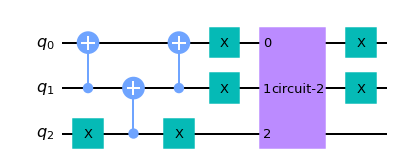

In [4]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

In [5]:
B=matrix_from_circuit(B_qc)
B

Matrix([
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

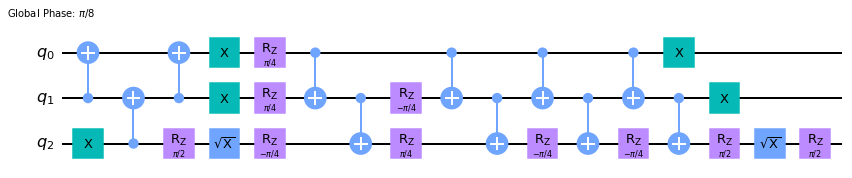

In [6]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [7]:
#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[ 0.33333 + 0.00012915*I, -0.66667 + 0.00012915*I, -0.66666 - 0.00025831*I,                   0],
[-0.66666 + 0.00012915*I,  0.33333 - 0.00025831*I, -0.66667 + 0.00012915*I,                   0],
[-0.66667 - 0.00025831*I, -0.66666 + 0.00012915*I,  0.33333 + 0.00012915*I,                   0],
[                      0,                       0,                       0, -1.0 + 1.8771e-16*I]])

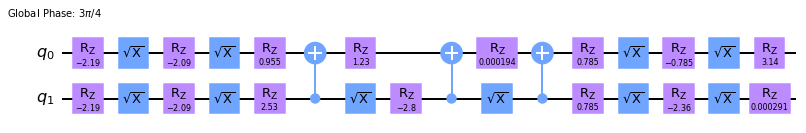

In [8]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

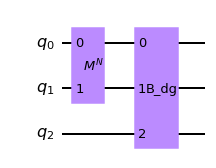

In [9]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr_U, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc_U.x(qr_U[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr_U[0],qr_U[1]])
qc_U.append(B_qc.inverse(),[qr_U[0],qr_U[1],qr_U[2]])

qc_U.draw(output="mpl")

In [10]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[                             0,                             0,                              0, -1.0,                              0,                             0,                              0,    0],
[-0.6666727298 - 0.0002583059*I, -0.6666605534 + 0.000129153*I,   0.3333332833 + 0.000129153*I,    0,                              0,                             0,                              0,    0],
[ -0.6666605534 + 0.000129153*I, 0.3333332833 - 0.0002583059*I,  -0.6666727298 + 0.000129153*I,    0,                              0,                             0,                              0,    0],
[                             0,                             0,                              0,    0,   0.3333332833 + 0.000129153*I, -0.6666727298 + 0.000129153*I, -0.6666605534 - 0.0002583059*I,    0],
[  0.3333332833 + 0.000129153*I, -0.6666727298 + 0.000129153*I, -0.6666605534 - 0.0002583059*I,    0,                              0,                             0,           

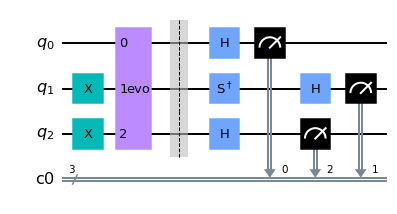

In [11]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [12]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [13]:
cal_circ[0].draw()

░ ┌─┐      
q94_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q94_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q94_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [14]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [16]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q98_0: ┤ X ├┤0     ├─────┤M├──────
       ├───┤│      │┌───┐└╥┘┌─┐   
q98_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
       ├───┤│      │├───┤ ║ └╥┘┌─┐
q98_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
       └───┘└──────┘└───┘ ║  ║ └╥┘
 c5: 3/═══════════════════╩══╩══╩═
                          0  1  2

In [17]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q97_0: ┤ X ├┤0     ├┤M├──────
       └───┘│      │└╥┘┌─┐   
q97_1: ─────┤1 evo ├─╫─┤M├───
            │      │ ║ └╥┘┌─┐
q97_2: ─────┤2     ├─╫──╫─┤M├
            └──────┘ ║  ║ └╥┘
 c4: 3/══════════════╩══╩══╩═
                     0  1  2

In [18]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [19]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [20]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[0.94165625,       0.05, 0.03396875, 0.00190625, 0.03103125,  0.0015625, 0.00109375,          0],
[  0.019125, 0.91171875,  0.0004375,  0.0335625,    0.00075, 0.02978125,   3.125e-5,  0.0013125],
[0.01084375,   0.000625,     0.9185, 0.04853125, 0.00040625,   3.125e-5, 0.03234375, 0.00178125],
[   0.00025, 0.01015625,  0.0186875,   0.887375,          0,   0.000375,  0.0005625, 0.02996875],
[0.02734375,  0.0014375,  0.0010625,  0.0001875,   0.938625, 0.04996875,  0.0340625, 0.00146875],
[ 0.0004375,  0.0256875,   3.125e-5,   0.000875, 0.01809375,   0.907875, 0.00053125,   0.030875],
[0.00034375,          0, 0.02678125, 0.00134375, 0.01096875,   0.000375,   0.913125, 0.04959375],
[         0,   0.000375, 0.00053125, 0.02621875,   0.000125, 0.01003125,    0.01825,      0.885]])

In [21]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[0.88684375, 0.06015625, 0.04678125, 0.00953125,     0.0395,    0.00375, 0.00321875,       0.01],
[0.02928125, 0.85940625,  0.0069375, 0.04353125, 0.00228125,   0.039875,    0.00975,   0.002125],
[0.02553125,      0.008, 0.86590625, 0.05878125, 0.00128125, 0.00934375, 0.04009375,   0.003625],
[0.00640625, 0.02290625,  0.0288125, 0.83746875, 0.00896875,    0.00125, 0.00221875,  0.0393125],
[   0.03875, 0.00303125, 0.00228125, 0.00890625,  0.8850625, 0.05903125,    0.04775, 0.00909375],
[0.00221875,  0.0359375,     0.0095, 0.00234375, 0.02996875, 0.85490625, 0.00740625,  0.0468125],
[ 0.0016875, 0.00928125, 0.03778125,  0.0035625,      0.026,  0.0076875, 0.85984375,  0.0560625],
[0.00928125, 0.00128125,      0.002,   0.035875,  0.0069375, 0.02415625, 0.02971875, 0.83296875]])

In [22]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [23]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [24]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1398_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1398_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1398_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c18: 3/══════╩════════════════╩══╩═
               1                0  2

In [25]:
meas_fitter_qiskit.cal_matrix

array([[9.4165625e-01, 5.0000000e-02, 3.3968750e-02, 1.9062500e-03,
        3.1031250e-02, 1.5625000e-03, 1.0937500e-03, 0.0000000e+00],
       [1.9125000e-02, 9.1171875e-01, 4.3750000e-04, 3.3562500e-02,
        7.5000000e-04, 2.9781250e-02, 3.1250000e-05, 1.3125000e-03],
       [1.0843750e-02, 6.2500000e-04, 9.1850000e-01, 4.8531250e-02,
        4.0625000e-04, 3.1250000e-05, 3.2343750e-02, 1.7812500e-03],
       [2.5000000e-04, 1.0156250e-02, 1.8687500e-02, 8.8737500e-01,
        0.0000000e+00, 3.7500000e-04, 5.6250000e-04, 2.9968750e-02],
       [2.7343750e-02, 1.4375000e-03, 1.0625000e-03, 1.8750000e-04,
        9.3862500e-01, 4.9968750e-02, 3.4062500e-02, 1.4687500e-03],
       [4.3750000e-04, 2.5687500e-02, 3.1250000e-05, 8.7500000e-04,
        1.8093750e-02, 9.0787500e-01, 5.3125000e-04, 3.0875000e-02],
       [3.4375000e-04, 0.0000000e+00, 2.6781250e-02, 1.3437500e-03,
        1.0968750e-02, 3.7500000e-04, 9.1312500e-01, 4.9593750e-02],
       [0.0000000e+00, 3.7500000e-04, 5.3

In [26]:
C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [27]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [28]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [29]:
raw_res.get_counts(-1)

{'000': 253,
 '010': 937,
 '011': 11891,
 '111': 1074,
 '100': 982,
 '001': 965,
 '110': 3517,
 '101': 12381}

In [30]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [31]:
qiskit_res.get_counts(-1)

{'000': 196.30602146838459,
 '001': 116.95010484420374,
 '010': 176.41931275341003,
 '011': 13367.179573416997,
 '100': 175.3222889106382,
 '101': 13595.43655812489,
 '110': 3787.2182149222967,
 '111': 585.1679255591806}

In [32]:
It_comp=occurrences_to_vector(itself_res.get_counts(-1))/(shots)
It_H=np.dot(Had3,It_comp)
Matrix(It_H)

Matrix([
[  0.35355339059357],
[0.0626718980509558],
[0.0547233326807091],
[0.0522717525016709],
[0.0870929135521274],
[0.0846413333989048],
[ 0.076692767805786],
[-0.214188724311973]])

In [33]:
itself_res.get_counts(0)

{'000': 2109.4421294975136,
 '001': 7.644034860109746e-05,
 '010': 7237.699117323255,
 '011': 7437.047859691685,
 '100': 4420.376614093974,
 '101': 6308.316966068003,
 '110': 0.00010134044795438949,
 '111': 4487.117135544771}

In [34]:
itself_res.get_counts(-1)

{'000': 6306.924827804005,
 '001': 6637.369750669782,
 '010': 6997.080762049186,
 '011': 4.514619629755976e-06,
 '100': 5532.2007526108855,
 '101': 5.0987613635213385e-06,
 '110': 5.5738618866889396e-08,
 '111': 6526.423897223813}

In [35]:
identity_res.get_counts(-1)

{'000': 3.78171390895346e-10,
 '001': 2.1303609360968157e-08,
 '010': 1.3749984967931967e-08,
 '011': 13993.752021277689,
 '100': 1.3624118430465745e-08,
 '101': 14244.535595107702,
 '110': 3746.2713171413784,
 '111': 15.441066432789288}

In [36]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.10871419, 0.11652535, 0.10122871, 0.14707971])

In [37]:
occurrences_to_vector(identity_res.get_counts(-1))

array([3.78171391e-10, 2.13036094e-08, 1.37499850e-08, 1.39937520e+04,
       1.36241184e-08, 1.42445356e+04, 3.74627132e+03, 1.54410664e+01])